<a href="https://colab.research.google.com/github/klackerman00/carpentry_tutorial/blob/main/ML_SST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Function

This function is creating a seperate variable from the initial variable, which is SST, that is time shifted by -1 time periods. 

Our initial SST data is at t = 0, always, then this next variable is going to be t = -1 for all of the time steps.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:
df = read_csv('*********** ', header=0)
df = df.drop(columns = ['Unnamed: 0'])
df1 = df[['wvht_51000', 'mwd_51000', 'wvht_moka', 'wvht_swan']]
#df1 = df1[::2]
df1 = df1.dropna()
          
owaves = df1['wvht_51000']
waves = df1['wvht_moka']
wdir = df1['mwd_51000']

rmax = np.amax(owaves)
rmin = np.amin(owaves)
fmax = np.amax(waves)
print(str(fmax) + ' ' + str(fmin))
fmin = np.amin(waves)
dmax = np.amax(wdir)
dmin = np.amin(wdir)

rrange = rmax-rmin # establishing range for both series
frange = fmax-fmin 
drange = dmax-dmin

nwind = (owaves-rmin)/rrange
print(np.amax(nwind))
nwaves = (waves-fmin)/frange
print(np.amax(nwaves))
ndir = (wdir-dmin)/drange
print(np.amax(ndir))

df2 = df1.copy()
df2['wvht_51000'] = nwind
df2['wvht_moka'] = nwaves
df2['mwd_51000'] = ndir
df2 = df2.drop(columns = ['wvht_swan'])
df2
values = df2.values
values = values.astype('float32')
df2.head()

5.34 0.58
1.0
1.0
1.0


,wvht_51000,mwd_51000,wvht_moka
1,0.092187,0.783333,0.193277
2,0.090625,0.447222,0.174370
3,0.089062,0.111111,0.182773
4,0.090625,0.112500,0.210084
5,0.092187,0.113889,0.189076


In [ ]:
reframed = series_to_supervised(values, 24, 1)
reframed1 = reframed[['var1(t-24)', 'var2(t-24)', 'var3(t-24)', 'var1(t-23)', 'var2(t-23)',
       'var3(t-23)', 'var1(t-22)', 'var2(t-22)', 'var3(t-22)', 'var1(t-21)',
       'var2(t-21)', 'var3(t-21)', 'var1(t-20)', 'var2(t-20)', 'var3(t-20)',
       'var1(t-19)', 'var2(t-19)', 'var3(t-19)', 'var1(t-18)', 'var2(t-18)',
       'var3(t-18)', 'var1(t-17)', 'var2(t-17)', 'var3(t-17)', 'var1(t-16)',
       'var2(t-16)', 'var3(t-16)', 'var1(t-15)', 'var2(t-15)', 'var3(t-15)',
       'var1(t-14)', 'var2(t-14)', 'var3(t-14)', 'var1(t-13)', 'var2(t-13)',
       'var3(t-13)', 'var1(t-12)', 'var2(t-12)', 'var3(t-12)', 'var1(t-11)',
       'var2(t-11)', 'var1(t-10)', 'var2(t-10)', 'var1(t-9)', 'var2(t-9)','var1(t-8)', 'var2(t-8)','var1(t-7)', 'var2(t-7)', 'var1(t-6)', 'var2(t-6)', 'var1(t-5)', 'var2(t-5)', 'var1(t-4)', 'var2(t-4)', 'var1(t-3)', 'var2(t-3)', 'var1(t-2)', 'var2(t-2)','var1(t-1)', 'var2(t-1)','var1(t)', 'var2(t)', 'var3(t)']]
values = reframed1.values



In [ ]:
values.shape

(49909, 64)

In [ ]:
n_train_hours = 365*24*2*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
train_X = np.delete(train_X, 1, 1)
test_X, test_y = test[:, :-1], test[:, -1]
test_X = np.delete(test_X, 1, 1)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(train_X)

(35040, 1, 62) (35040,) (14869, 1, 62) (14869,)


In [ ]:
train_y

array([0.1869748 , 0.1869748 , 0.16596639, ..., 0.44747898, 0.44537815,
       0.3907563 ], dtype=float32)

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35040 samples, validate on 14869 samples
Epoch 1/50
 - 3s - loss: 0.0575 - val_loss: 0.0491
Epoch 2/50
 - 1s - loss: 0.0428 - val_loss: 0.0499
Epoch 3/50
 - 1s - loss: 0.0408 - val_loss: 0.0513
Epoch 4/50
 - 1s - loss: 0.0396 - val_loss: 0.0517
Epoch 5/50
 - 1s - loss: 0.0388 - val_loss: 0.0501
Epoch 6/50
 - 1s - loss: 0.0381 - val_loss: 0.0488
Epoch 7/50
 - 1s - loss: 0.0377 - val_loss: 0.0479
Epoch 8/50
 - 1s - loss: 0.0374 - val_loss: 0.0481
Epoch 9/50
 - 1s - loss: 0.0371 - val_loss: 0.0468
Epoch 10/50
 - 1s - loss: 0.0368 - val_loss: 0.0452
Epoch 11/50
 - 1s - loss: 0.0366 - val_loss: 0.0450
Epoch 12/50
 - 1s - loss: 0.0364 - val_loss: 0.0448
Epoch 13/50
 - 1s - loss: 0.0362 - val_loss: 0.0438
Epoch 14/50
 - 1s - loss: 0.0361 - val_loss: 0.0433
Epoch 15/50
 - 1s - loss: 0.0360 - val_loss: 0.0424
Epoch 16/50
 - 1s - loss: 0.0359 - val_loss: 0.0411
Epoch 17/50
 - 1s - loss: 0.0358 - val_loss: 0.0404
Epoch 18/50
 - 1s - loss: 0.0357 - val_loss: 0.0405
Epoch 19/50
 - 1s - los

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

NameError: ignored

In [ ]:
yhat = model.predict(test_X)
#unnormalize the units
inv_yhat = (yhat*frange)+fmin # multiplied by two to better fit the data, can easily remove
inv_testy = ((test_y*frange)+fmin)
print(len(inv_yhat))
print(len(inv_testy))
dftest = df1[n_train_hours+24::]
print(len(dftest))

14869
14869
14869


14869

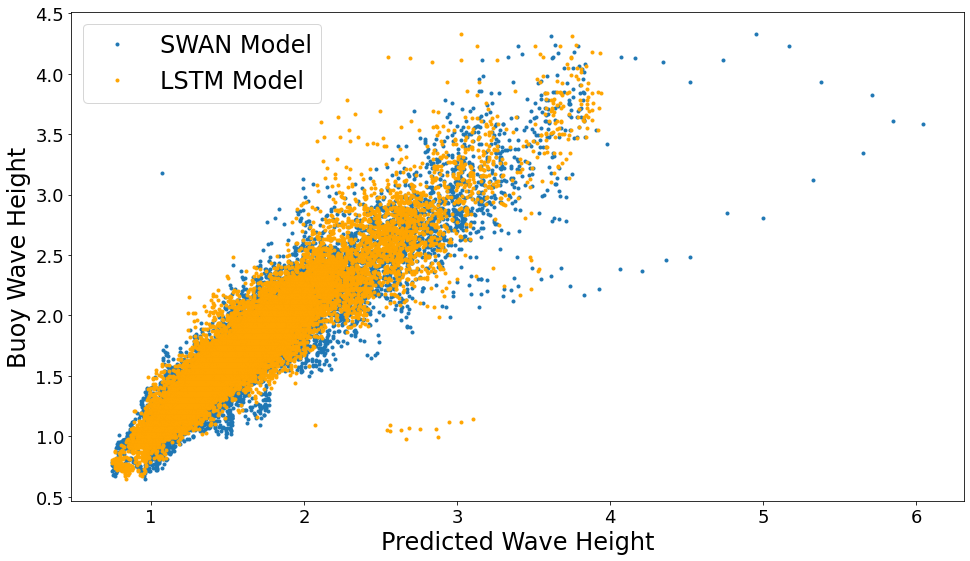

In [ ]:

buoy = dftest['wvht_moka']
swan = dftest['wvht_swan']
pyplot.figure(figsize=(16, 9))
pyplot.plot(swan, buoy, '.', label = 'SWAN Model')
pyplot.plot(inv_yhat, buoy, '.', color = 'orange', label = 'LSTM Model')

pyplot.plot()
pyplot.xlabel('Predicted Wave Height', fontsize = 24)
pyplot.xticks(fontsize=18)
pyplot.yticks(fontsize=18)
pyplot.ylabel('Buoy Wave Height', fontsize = 24)
pyplot.legend(fontsize = 24)
len(inv_yhat)

<Figure size 432x288 with 0 Axes>

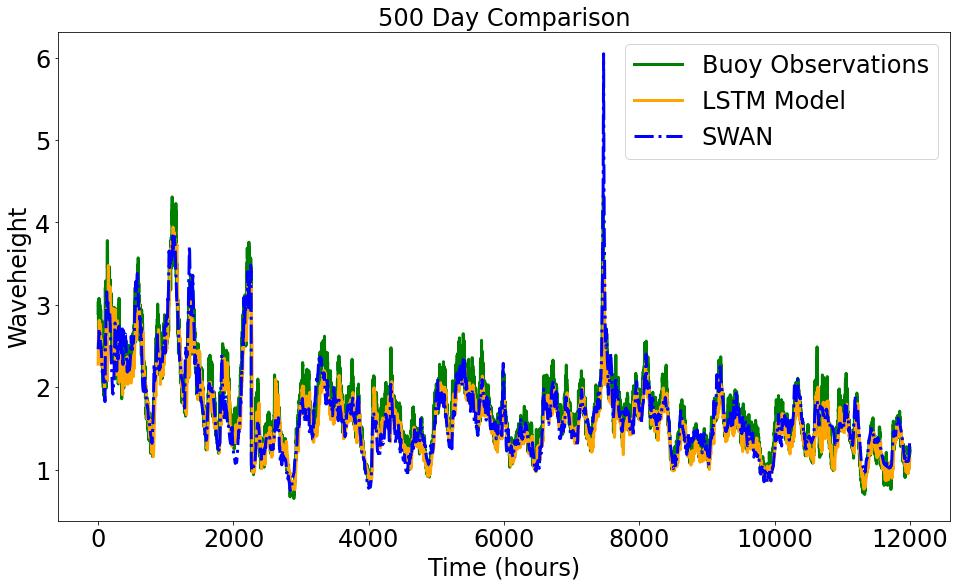

In [ ]:
pyplot.figure()
i=24
n=12000
rng=np.s_[i:i+n]
xx=np.arange(n)
rngmodel = np.s_[i:i+n]
#untest_y = (test_y*frange)+fmin
#unyhat = (yhat*frange)+fmin

pyplot.figure(figsize=(16, 9))
pyplot.plot(xx,inv_testy[rngmodel],'g', linewidth = 3, label = 'Buoy Observations')
pyplot.plot(xx,inv_yhat[rngmodel],'orange', linewidth = 3, label = 'LSTM Model')
pyplot.plot(xx,swan[rngmodel],'b-.', linewidth = 3, label = 'SWAN')
#pyplot.plot(xx,inv_yhat[rng],'g:', linewidth = 3, label = 'LSTM Model')
pyplot.xlabel('Time (hours)', fontsize = 24)
pyplot.xticks(fontsize=24)
pyplot.yticks(fontsize=24)
pyplot.ylabel('Waveheight', fontsize = 24)
pyplot.title('500 Day Comparison', fontsize = 24)
pyplot.legend(fontsize = 24)
pyplot.show()

<Figure size 432x288 with 0 Axes>

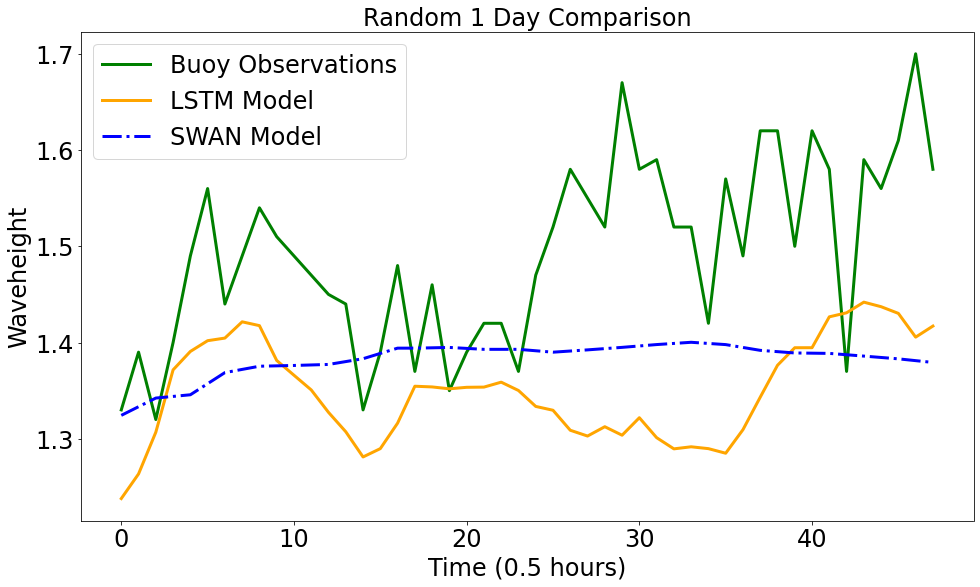

In [ ]:
pyplot.figure()
i=2500
n=48
rng=np.s_[i:i+n]
rngmodel = np.s_[i:i+n]
xx=np.arange(n)
#untest_y = (test_y*frange)+fmin
#unyhat = (yhat*frange)+fmin

pyplot.figure(figsize=(16, 9))
pyplot.plot(xx,buoy[rng],'g', linewidth = 3, label = 'Buoy Observations')
#pyplot.plot(xx,inv_yhat[rng],'g:', linewidth = 3, label = 'LSTM Model')
pyplot.plot(xx,inv_yhat[rngmodel],'orange', linewidth = 3, label = 'LSTM Model')
#pyplot.plot(xx,inv_yhat[rngmodel],'g-.', linewidth = 3, label = 'LSTM Model')
pyplot.plot(xx,swan[rngmodel],'b-.', linewidth = 3, label = 'SWAN Model')
pyplot.xlabel('Time (0.5 hours)', fontsize = 24)
pyplot.ylabel('Waveheight', fontsize = 24)
pyplot.xticks(fontsize=24)
pyplot.yticks(fontsize=24)
pyplot.title('Random 1 Day Comparison', fontsize = 24)
pyplot.legend(fontsize = 24)
pyplot.show()

<Figure size 432x288 with 0 Axes>

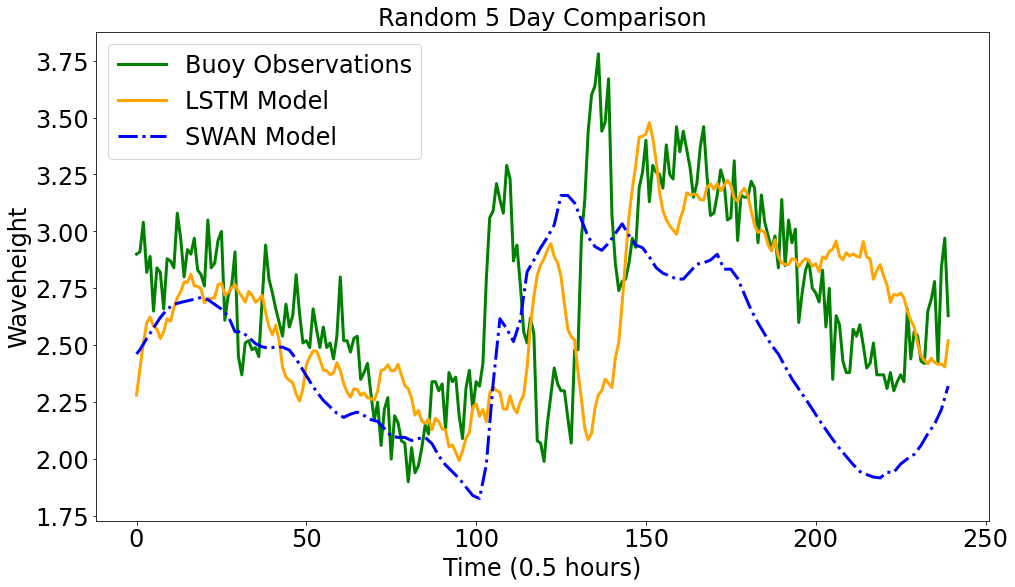

In [ ]:
pyplot.figure()
i=24
n=240
rng=np.s_[i:i+n]
#rngmodel = np.s_[i-24:i+n-24]
xx=np.arange(n)
#untest_y = (test_y*frange)+fmin
#unyhat = (yhat*frange)+fmin

pyplot.figure(figsize=(16, 9))
pyplot.plot(xx,buoy[rng],'g', linewidth = 3, label = 'Buoy Observations')
pyplot.plot(xx,inv_yhat[rng],'orange', linewidth = 3, label = 'LSTM Model')
pyplot.plot(xx,swan[rng],'b-.', linewidth = 3, label = 'SWAN Model')
pyplot.xlabel('Time (0.5 hours)', fontsize = 24)
pyplot.ylabel('Waveheight', fontsize = 24)
pyplot.xticks(fontsize=24)
pyplot.yticks(fontsize=24)
pyplot.title('Random 5 Day Comparison', fontsize = 24)
pyplot.legend(fontsize = 24)
pyplot.show()

In [ ]:
len(inv_yhat), len(swan)

(14869, 14869)

In [ ]:
print('LSTM Model Error ' + str(mean_squared_error(inv_yhat, buoy)))
print('SWAN Model Error ' + str(mean_squared_error(swan, buoy)))

LSTM Model Error 0.04902259999677727
SWAN Model Error 0.05271834400795892
